In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import resample
from sklearn.datasets import load_iris, load_breast_cancer, load_wine
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score,precision_score, recall_score
import nltk
import pickle
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler
# Establecer semilla para reproducibilidad
np.random.seed(42)

In [2]:

def gini_impurity(y):
    """Calcular la impureza Gini de un array de etiquetas"""
    if len(y) == 0:
        return 0
    # Proporción de cada clase
    clases = np.unique(y)
    probabilities = [np.mean(y == c) for c in clases]
    gini = 1 - sum(p ** 2 for p in probabilities)
    return gini

def entropy(y):
    """Calcular la entropía de un array de etiquetas"""
    if len(y) == 0:
        return 0
    # Proporción de cada clase
    clases = np.unique(y)
    probabilities = [np.mean(y == c) for c in clases]
    # Usamos log2 para calcular la entropía
    entropy_value = -sum(p * np.log2(p) for p in probabilities if p > 0)
    return entropy_value

def information_gain(y, left_indices, right_indices, impurity_function=gini_impurity):
    """Calcular la ganancia de información de una división utilizando impureza Gini o entropía"""
    parent_impurity = impurity_function(y)

    # Subconjuntos izquierdo y derecho
    left_impurity = impurity_function(y[left_indices])
    right_impurity = impurity_function(y[right_indices])

    # Peso de los subconjuntos izquierdo y derecho
    left_weight = len(left_indices) / len(y)
    right_weight = len(right_indices) / len(y)

    # Impureza ponderada de los hijos
    weighted_impurity = left_weight * left_impurity + right_weight * right_impurity

    # Ganancia de información
    info_gain = parent_impurity - weighted_impurity
    return info_gain

class DecisionTree:
    def __init__(self, max_depth=None, impurity_function=gini_impurity, min_samples_split=2,
                 min_samples_leaf=1):
        self.max_depth = max_depth
        self.impurity_function = impurity_function
        self.tree = None

        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
    def fit(self, X, y):
        """Ajustar el árbol de decisión a los datos"""
        self.tree = self._build_tree(X, y, depth=0)

    def _build_tree(self, X, y, depth):
        n_samples, n_features = X.shape
        n_labels = len(np.unique(y))

        if (n_samples < self.min_samples_split
            or len(np.unique(y)) == 1
            or (self.max_depth and depth == self.max_depth)):
            return np.bincount(y).argmax()
        # Si ya es un nodo hoja o alcanzamos la profundidad máxima ya no dividimos
        if n_labels == 1 or (self.max_depth and depth == self.max_depth):
            return np.unique(y)[0]

        # Buscamos el atributo que gane más información
        best_gain = -1 # Valor de inicio
        best_split = None
        best_left_indices = None
        best_right_indices = None

        # Por cada caracterísitca o dimensión
        for feature in range(n_features):
            # Limitar cantidad de thresholds por feature usando percentiles
            # Esto para limitar la cantidad de separaciones
            valores = np.percentile(X[:,feature], np.linspace(5, 95, 19))
            valores = np.unique(valores)
            # Sacamos las ramas
            for i in range(1, len(valores)):
                # Para que funcione con datos continuos sin la necesidad de discretizar
                threshold = (valores[i - 1] + valores[i]) / 2
                left_indices = np.where(X[:, feature] <= threshold)[0]
                right_indices = np.where(X[:, feature] > threshold)[0]
                # Descarta divisiones que dejen muy pocas muestras en una rama
                if (len(left_indices) < self.min_samples_leaf
                    or len(right_indices) < self.min_samples_leaf):
                    continue

                if len(left_indices) == 0 or len(right_indices) == 0:
                    continue

                gain = information_gain(y, left_indices, right_indices, self.impurity_function)

                if gain > best_gain:
                    best_gain = gain
                    best_split = {
                        "feature": feature,
                        "value": threshold
                    }
                    best_left_indices = left_indices
                    best_right_indices = right_indices
             # Si no se encontró una mejor división, retornamos la clase mayoritaria
        if best_gain == -1:
            return np.bincount(y).argmax()

        # Construir recursivamente las ramas
        left_subtree = self._build_tree(X[best_left_indices], y[best_left_indices], depth + 1)
        right_subtree = self._build_tree(X[best_right_indices], y[best_right_indices], depth + 1)
        return {
        "feature": best_split["feature"],
        "value": best_split["value"],
        "left": left_subtree,
        "right": right_subtree
        }

    def predict_one(self, x, node=None):
        """Predecir una muestra individual"""
        if node is None:
            node = self.tree

        if not isinstance(node, dict):
            return node

        feature = node["feature"]
        value = node["value"]

        if x[feature] <= value:
            return self.predict_one(x, node["left"])
        else:
            return self.predict_one(x, node["right"])
    def get_params(self, deep=True):
        """Obtener los parámetros del modelo"""
        return {"max_depth": self.max_depth, "impurity_function": self.impurity_function}

    def set_params(self, **params):
        """Configurar los parámetros del modelo"""
        for param, value in params.items():
            setattr(self, param, value)
        return self

    def predict(self, X):
        """Predecir múltiples muestras"""
        return np.array([self.predict_one(x) for x in X])




In [ ]:
_TESTING = False

if _TESTING:
    _NROWS = 1000
else:
    _NROWS = None


dataset_path = "./data/spotify_dataset_sin_duplicados_4.csv"
df = pd.read_csv(dataset_path, nrows=_NROWS)
print(df.columns)
#print(df["Explicit"].unique)
#print(df["Danceability"].unique)
print(df["Loudness (db)"].unique)


Index(['Artist(s)', 'song', 'text', 'Length', 'emotion', 'Genre', 'Album',
       'Release Date', 'Key', 'Tempo', 'Loudness (db)', 'Time signature',
       'Explicit', 'Popularity', 'Energy', 'Danceability', 'Positiveness',
       'Speechiness', 'Liveness', 'Acousticness', 'Instrumentalness',
       'Good for Party', 'Good for Work/Study',
       'Good for Relaxation/Meditation', 'Good for Exercise',
       'Good for Running', 'Good for Yoga/Stretching', 'Good for Driving',
       'Good for Social Gatherings', 'Good for Morning Routine',
       'Similar Artist 1', 'Similar Song 1', 'Similarity Score 1',
       'Similar Artist 2', 'Similar Song 2', 'Similarity Score 2',
       'Similar Artist 3', 'Similar Song 3', 'Similarity Score 3',
       'song_normalized', 'artist_normalized'],
      dtype='object')
<bound method Series.unique of 0       -6.85db
1       -5.75db
2      -13.78db
3      -10.54db
4      -12.76db
         ...   
995    -12.85db
996       -12db
997    -12.77db
998       

In [4]:
import nltk
# Comprueba ruta:
print(nltk.data.path[0]) 
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')


/home/marcelino.maita/nltk_data


[nltk_data] Downloading package punkt to
[nltk_data]     /home/marcelino.maita/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /home/marcelino.maita/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/marcelino.maita/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:

from text_preprocessing import TextPreprocessor, TFIDFVectorizer

preprocessor = TextPreprocessor()
# Juntar columnas
# columns_to_use = ['text', 'song', 'Artist(s)', 'Album', 'Similar Artist 1', 'Genre']
columns_to_use = ['text', 'song', 'Artist(s)', 'Album', 'Similar Artist 1', 'Genre']
df['combined_text'] = df[columns_to_use].fillna('').agg(' '.join, axis=1)

preprocessor = TextPreprocessor()
df['text_processed'] = df['combined_text'].apply(preprocessor.preprocess)

vectorizer = TFIDFVectorizer(max_features=1000)
X = vectorizer.fit_transform(df['text_processed'].tolist())



In [8]:
pd.DataFrame(X).to_csv("./data/X_tfidf_las_df.csv", index=False)

In [11]:
df['Loudness (db)'] = df['Loudness (db)'].astype(str).str.replace('db', '', regex=False)
df['Loudness (db)'] = pd.to_numeric(df['Loudness (db)'], errors='coerce')
# Asegurarse que tenga data
df[['Danceability', 'Loudness (db)']] = df[['Danceability', 'Loudness (db)']].fillna(0)
scaler = StandardScaler()
X_num = scaler.fit_transform(df[['Danceability', 'Loudness (db)']])

X = pd.read_csv("./data/X_tfidf_las_df.csv").values
X = np.concatenate([X, X_num], axis=1)



In [12]:
print(X.shape)

(1000, 1002)


Accuracy: 0.8850
Precision: 0.9167
F1 Score: 0.9199
[[ 45  12]
 [ 11 132]]


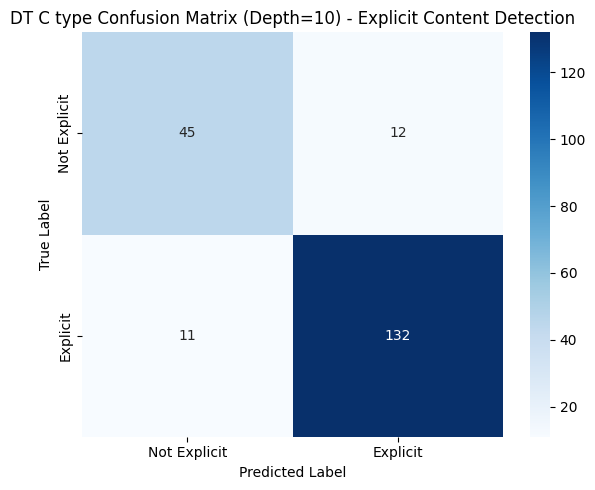

In [13]:
df['Explicit_binary'] = df['Explicit'].map({'Yes': 1, 'No': 0})
y = df['Explicit_binary'].values

depths = [10]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


for depth in depths:
    tree = DecisionTree(max_depth=depth)
    tree.fit(X_train, y_train)
    y_pred = tree.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)

    # Mostrar las métricas
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(cm)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Not Explicit', 'Explicit'],
                yticklabels=['Not Explicit', 'Explicit'])

    # Etiquetas personalizadas
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'DT C type Confusion Matrix (Depth={depth}) - Explicit Content Detection')

    plt.tight_layout()

    # Guardar imagen
    # plt.savefig( str(depth) + "confusion_matrix_C_type.png")
    # plt.close()

    # with open(f"decision_tree_model_depth_{depth}.pkl", "wb") as f:
    #     pickle.dump(tree, f)


    

Accuracy: 0.8829
Precision: 0.8173
F1 Score: 0.7653
[[9010  556]
 [ 969 2487]]
